In [247]:
%matplotlib inline
import torch
from torch import nn
from torch import optim



import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# LSTM and GRU with numpy

## 1. GRU

In [21]:
# Activation functions and derivatives
def sigm(x):
    return 1 / (1 + np.exp(-x))

def dsigm(x):
    return x * (1 - x)

def tanh(x):
    return np.tanh(x)

def dtanh(x):
    return (1 - np.square(x))

def relu(x):
    return np.maximum(0, x)

def drelu(x):
    return np.array(x > 0, dtype=int)

### 1.1 Numpy implementation

In [134]:
class GRU:
    def __init__(self, input_size, hidden_size):
        r'''
        Simple version of Cho & al. GRU. Here we only on train on batch of size 1.
        
        Args:
            input_size: input size of tensors of shape :math:`(\text{minibatch} , \text{in\_channels} , iW)`
            hidden_size: the number of hidden nodes and also the output size
            
        Examples::
        
            >>> input = np.ones((10,10))
            >>> net = GRU(input_size=10, hidden_size=5)
            >>> net.forward(input)
        '''
        # Weights dimensions
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Standard deviation for weights initialisation
        wstd = 0.2
        
        # Reset gate
        self.Wr = np.random.randn(hidden_size + input_size, hidden_size)*wstd
        self.br = np.zeros((hidden_size,))
        
        # Update gate
        self.Wz = np.random.randn(hidden_size + input_size, hidden_size) * wstd
        self.bz = np.zeros((hidden_size,))
        
        # Hidden proposal (\hat{h})
        self.Whhat = np.random.randn(hidden_size + input_size, hidden_size) * wstd
        self.bhhat = np.zeros((hidden_size,))
        
    def __str__(self):
        return "input_size: {}\nhidden_size: {}".format(self.input_size, self.hidden_size)
    
    def forward(self, input):
        r'''
        Do the forward pass for a single input (batch size = 1).
        
        Args:
            input (Numpy Array): the expected dimension of input array/tensor is (seq_len, input_size), 
                where seq_len is the length of the sequence (eg. number of words, number of characters, 
                length of the time serie) and input_size is the number of features in the input.
        
        Examples::
        
            >>> input = np.ones((10,10))
            >>> net = GRU(input_size=10, hidden_size=5)
            >>> net.forward(input)
        '''
        seq_len = np.shape(input)[0]
        
        # Gates output tensors
        z = np.zeros((seq_len, self.hidden_size))
        r = np.zeros((seq_len, self.hidden_size))
        hhat = np.zeros((seq_len, self.hidden_size))
        h = np.zeros((seq_len, self.hidden_size))
        
        for i in range(seq_len):
            x = np.concatenate((h[i-1,:], input[i,:])) # h[i-1,:] = h_{t-1} and input[i,:] = x_t
            
            # Reset gate
            r[i,:] = sigm(np.dot(x, self.Wr) + self.br)           
            # Output gate
            z[i,:] = sigm(np.dot(x, self.Wz) + self.bz)
            # Hidden state proposal
            hhat[i,:] = tanh(np.dot(np.concatenate((r[i,:] * h[i-1,:], input[i,:])), self.Whhat) + self.bhhat)
            # Hidden state
            h[i,:] = (1 - z[i,:]) * h[i-1,:] + z[i,:] * hhat[i,:]
        
        return h

    def backward(self, input, grad):
        dWhhat, dWr, dWz = np.zeros_like(self.Whhat), np.zeros_like(self.Wr), np.zeros_like(self.Wz)
        dby, dbh, dbr, dbz = np.zeros_like(by), np.zeros_like(bh), np.zeros_like(br), np.zeros_like(bz)
        dhnext = np.zeros_like(h[0])
        # Backward prop
        for t in reversed(range(len(input))):
            # ∂loss/∂y
            #dy = np.copy(p[t])
            #dy[targets[t]] -= 1

            # ∂loss/∂Wy and ∂loss/∂by
            #dWy += np.dot(dy, h[t].T)
            #dby += dy

            # Intermediary derivatives
            #dh = np.dot(Wy.T, dy) + dhnext
            #dh_hat = np.multiply(dh, (1 - z[t]))
            #dh_hat_l = dh_hat * tanh(h_hat[t], deriv=True)

            # ∂loss/∂Wh, ∂loss/∂Uh and ∂loss/∂bh
            x = np.concat(x[t].T, np.multiply(r[t], h[t-1])
            dWh += np.dot(dh_hat_l, x)
            dbh += dh_hat_l

            # Intermediary derivatives
            drhp = np.dot(Uh.T, dh_hat_l)
            dr = np.multiply(drhp, h[t-1])
            dr_l = dr * sigmoid(r[t], deriv=True)

            # ∂loss/∂Wr, ∂loss/∂Ur and ∂loss/∂br
            dWr += np.dot(dr_l, x[t].T)
            dUr += np.dot(dr_l, h[t-1].T)
            dbr += dr_l

            # Intermediary derivatives
            dz = np.multiply(dh, h[t-1] - h_hat[t])
            dz_l = dz * sigmoid(z[t], deriv=True)

            # ∂loss/∂Wz, ∂loss/∂Uz and ∂loss/∂bz
            dWz += np.dot(dz_l, x[t].T)
            dUz += np.dot(dz_l, h[t-1].T)
            dbz += dz_l

            # All influences of previous layer to loss
            dh_fz_inner = np.dot(Uz.T, dz_l)
            dh_fz = np.multiply(dh, z[t])
            dh_fhh = np.multiply(drhp, r[t])
            dh_fr = np.dot(Ur.T, dr_l)

            # ∂loss/∂h𝑡₋₁
            dhnext = dh_fz_inner + dh_fz + dh_fhh + dh_fr

        return sequence_loss, dWy, dWh, dWr, dWz, dUh, dUr, dUz, dby, dbh, dbr, dbz, h[len(inputs) - 1]

In [135]:
input = np.ones((10,10))

net = GRU(input_size=10, hidden_size=5)

net.forward(input)

array([[ 0.02295972,  0.23587031, -0.390115  ,  0.1746599 ,  0.17550338],
       [ 0.02192101,  0.41689426, -0.52664695,  0.2786006 ,  0.3004084 ],
       [ 0.01625149,  0.53003645, -0.57954693,  0.33884566,  0.38846527],
       [ 0.01021492,  0.59377058, -0.60233494,  0.37298913,  0.45010513],
       [ 0.00447726,  0.62778577, -0.61282582,  0.39184535,  0.49304813],
       [-0.00076642,  0.64548838, -0.61772325,  0.40189856,  0.52286429],
       [-0.00534615,  0.65464511, -0.6199439 ,  0.40698109,  0.54350852],
       [-0.00915993,  0.65942042, -0.62088178,  0.40932951,  0.55776629],
       [-0.0122026 ,  0.66196111, -0.62122364,  0.4102295 ,  0.56759042],
       [-0.01454462,  0.66335375, -0.62130455,  0.41040527,  0.57434512]])

### 1.2 Pytorch implementation

In [287]:
class GRU_torch(nn.Module):
    def __init__(self, input_size, hidden_size):
        r'''
        Simple version of Cho & al. GRU. Here we only on train on batch of size 1.
        
        Args:
            input_size: input size of tensors of shape :math:`(\text{minibatch} , \text{in\_channels} , iW)`
            hidden_size: the number of hidden nodes and also the output size
            
        Examples::
        
            >>> input = np.ones((10,10))
            >>> net = GRU(input_size=10, hidden_size=5)
            >>> net.forward(input)
        '''
        super(GRU_torch, self).__init__()
        # Weights dimensions
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Standard deviation for weights initialisation
        wstd = 0.2
        
        # Reset gate
        self.Wr = torch.nn.Parameter(torch.randn((hidden_size, input_size), requires_grad=True) * wstd)
        self.Ur = torch.nn.Parameter(torch.randn((hidden_size, hidden_size), requires_grad=True) * wstd)
        self.br = torch.nn.Parameter(torch.zeros((hidden_size,), requires_grad=True))
        
        # Update gate
        self.Wz = torch.nn.Parameter(torch.randn((hidden_size, input_size), requires_grad=True) * wstd)
        self.Uz = torch.nn.Parameter(torch.randn((hidden_size, hidden_size), requires_grad=True) * wstd)
        self.bz = torch.nn.Parameter(torch.zeros((hidden_size,), requires_grad=True))
        
        # Hidden proposal (\hat{h})
        self.Whhat = torch.nn.Parameter(torch.randn((hidden_size, input_size), requires_grad=True) * wstd)
        self.Uhhat = torch.nn.Parameter(torch.randn((hidden_size, hidden_size), requires_grad=True) * wstd)
        self.bhhat = torch.nn.Parameter(torch.zeros((hidden_size,), requires_grad=True))
        
    def __str__(self):
        return "input_size: {}\nhidden_size: {}".format(self.input_size, self.hidden_size)
    
    def forward(self, input):
        r'''
        Do the forward pass for a single input (batch size = 1).
        
        Args:
            input (Numpy Array): the expected dimension of input array/tensor is (seq_len, input_size), 
                where seq_len is the length of the sequence (eg. number of words, number of characters, 
                length of the time serie) and input_size is the number of features in the input.
        
        Examples::
        
            >>> input = np.ones((10,10))
            >>> net = GRU(input_size=10, hidden_size=5)
            >>> net.forward(input)
        '''
        
        # Hidden state is initially set at 0
        h = torch.zeros(self.hidden_size)
        
        for i in range(np.shape(input)[0]):
            # Reset gate
            r = torch.sigmoid(self.Wr.matmul(input[i, :]) + self.Ur.matmul(h) + self.br)           
            # Output gate
            z = torch.sigmoid(self.Wz.matmul(input[i, :]) + self.Uz.matmul(h) + self.bz)
            # Hidden state proposal
            hhat = torch.tanh(self.Whhat.matmul(input[i, :]) + self.Uhhat.matmul(r * h) + self.bhhat)
            # Hidden state
            h = (1 - z) * h + z * hhat
            
        return h

In [304]:
input = torch.ones((2, 5))
net = GRU_torch(5, 10)

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)

hist_loss = []

for i in range(100):
    net.zero_grad()
    output = net.forward(input)
    loss = criterion(output, torch.ones_like(out))
    
    hist_loss.append(loss.detach().numpy())
    
    loss.backward()
    optimizer.step()

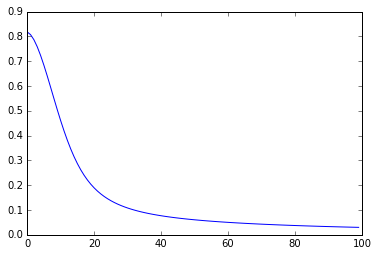

In [305]:
plt.plot(hist_loss)
plt.show()